In [ ]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install seaborn --upgrade

In [5]:
import pandas as pd

df = pd.read_csv("dataset/twitter_multi_class_sentiment.csv")

In [3]:
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        16000 non-null  object
 1   label       16000 non-null  int64 
 2   label_name  16000 non-null  object
dtypes: int64(1), object(2)
memory usage: 375.1+ KB


In [6]:
df.isna().sum()

,0
text,0
label,0
label_name,0


In [6]:
df['label'].value_counts().sort_index()

label
0    4666
1    5362
2    1304
3    2159
4    1937
5     572
Name: count, dtype: int64

In [8]:
import matplotlib.pyplot as plt

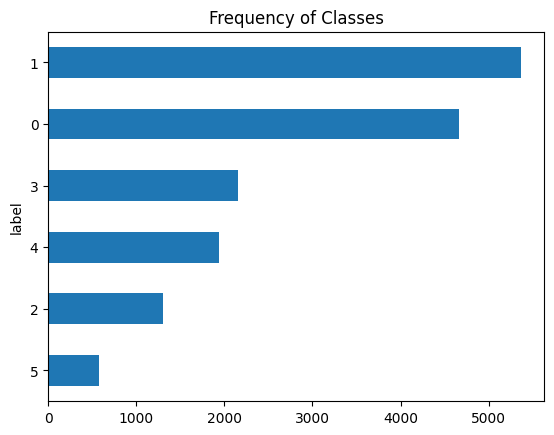

In [9]:
label_count = df['label'].value_counts().sort_values(ascending=True)

label_count.plot(kind='barh')
plt.title('Frequency of Classes')
plt.show()

In [7]:
df['words_per_tweet'] = df['text'].str.split().apply(len)

<Axes: title={'center': 'words_per_tweet'}, xlabel='label_name'>

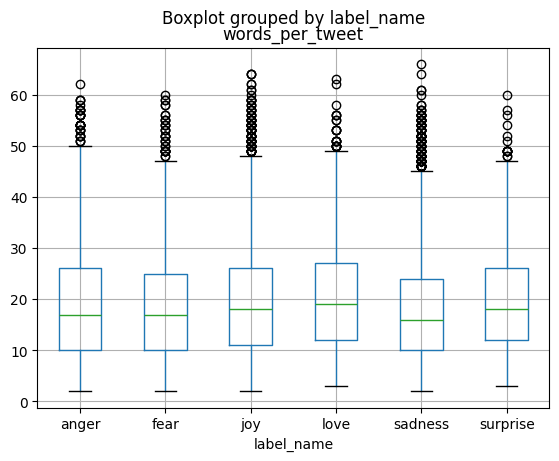

In [11]:
df.boxplot('words_per_tweet', by = 'label_name')

AutoTokenizer is a powerful tool that automatically selects the appropriate tokenizer based on the model you specify.

In [8]:
from transformers import AutoTokenizer

model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)


text = "I love machine learning! Tokenization is awesome!!"
encoded_text = tokenizer(text)
print(encoded_text)

c:\Users\RAJ\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\RAJ\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\RAJ\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator

{'input_ids': [101, 1045, 2293, 3698, 4083, 999, 19204, 3989, 2003, 12476, 999, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [13]:
len(tokenizer.vocab), tokenizer.vocab_size, tokenizer.model_max_length

(30522, 30522, 512)

*    **tokenizer.vocab:** This is an attribute of the tokenizer object and likely   represents the vocabulary as a dictionary-like structure where words (or tokens) are keys and their corresponding IDs are values.
*    **len(tokenizer.vocab):** This part of the code calculates the length of the vocabulary, essentially telling you how many unique words or tokens the tokenizer recognizes.
*    **tokenizer.vocab_size**: This is another attribute that directly provides the size of the tokenizer's vocabulary. It should give you the same result as len(tokenizer.vocab).
*    **tokenizer.model_max_length:** This attribute specifies the maximum number of tokens that can be input to the BERT model. If your input text has more tokens than this limit, you'll need to truncate it.


## Data Loader and Train Test Split

stratify=df['label_name']: This ensures that the proportion of each class (represented by the 'label_name' column) is maintained in both the training and testing sets. This is important for balanced model training.

In [14]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, stratify=df['label_name'])
test, validation = train_test_split(test, test_size=1/3, stratify=test['label_name'])

train.shape, test.shape, validation.shape

((11200, 4), (3200, 4), (1600, 4))

In [15]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict(
    {'train':Dataset.from_pandas(train, preserve_index=False),
     'test':Dataset.from_pandas(test, preserve_index=False),
     'validation': Dataset.from_pandas(validation, preserve_index=False)
     }

)

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'words_per_tweet'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'words_per_tweet'],
        num_rows: 3200
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'words_per_tweet'],
        num_rows: 1600
    })
})

## Tokenization of the Emotion/Sentiment Data

In [16]:
dataset['train'][0], dataset['train'][1]

({'text': 'i have definitely felt the stirrings of spring and although i expect more winter weather in march i feel assured that the seasons are changing',
  'label': 1,
  'label_name': 'joy',
  'words_per_tweet': 25},
 {'text': 'i apologize to anyone who may feel i have been a neglectful slacker mcslackerson',
  'label': 0,
  'label_name': 'sadness',
  'words_per_tweet': 14})

In [17]:
def tokenize(batch):
  temp = tokenizer(batch['text'], padding=True, truncation=True)
  return temp

In [18]:
print(tokenize(dataset['train'][:2]))

{'input_ids': [[101, 1045, 2031, 5791, 2371, 1996, 18385, 2015, 1997, 3500, 1998, 2348, 1045, 5987, 2062, 3467, 4633, 1999, 2233, 1045, 2514, 8916, 2008, 1996, 3692, 2024, 5278, 102], [101, 1045, 12134, 2000, 3087, 2040, 2089, 2514, 1045, 2031, 2042, 1037, 19046, 3993, 19840, 2121, 11338, 14540, 25418, 3385, 102, 0, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]]}


In [19]:
emotion_encoded = dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/11200 [00:00<?, ? examples/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

In [20]:
emotion_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'words_per_tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'words_per_tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3200
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'words_per_tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1600
    })
})

In [21]:
# label2id, id2label
label2id = {x['label_name']:x['label'] for x in dataset['train']}
id2label = {v:k for k,v in label2id.items()}

label2id, id2label

({'joy': 1, 'sadness': 0, 'anger': 3, 'fear': 4, 'love': 2, 'surprise': 5},
 {1: 'joy', 0: 'sadness', 3: 'anger', 4: 'fear', 2: 'love', 5: 'surprise'})

## Model Building

In [22]:
from transformers import AutoModel
import torch

In [23]:
model = AutoModel.from_pretrained(model_ckpt)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [24]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [25]:
model.config


BertConfig {
  "_attn_implementation_autoset": true,
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.50.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

## Fine-Tuning Transformers

In [26]:
from transformers import AutoModelForSequenceClassification, AutoConfig

num_labels = len(label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
model.config

BertConfig {
  "_attn_implementation_autoset": true,
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "sadness",
    "1": "joy",
    "2": "love",
    "3": "anger",
    "4": "fear",
    "5": "surprise"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 3,
    "fear": 4,
    "joy": 1,
    "love": 2,
    "sadness": 0,
    "surprise": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.50.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [28]:
from transformers import TrainingArguments

batch_size = 64
training_dir = "bert_base_train_dir"

training_args = TrainingArguments( output_dir=training_dir,
                                  overwrite_output_dir = True,
                                  num_train_epochs = 5,
                                  learning_rate = 2e-5,
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size = batch_size,
                                  weight_decay = 0.01,
                                  evaluation_strategy = 'epoch',
                                  disable_tqdm = False,
                                  report_to="none"
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [29]:
# use sklearn to build compute metrics
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)

    return {"accuracy": acc, "f1": f1}


## Build Model and Trainer

In [30]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset = emotion_encoded['train'],
                  eval_dataset = emotion_encoded['validation'],
                  tokenizer = tokenizer
                  )

<ipython-input-30-8efc9adb5e63>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


In [31]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.397319,0.880000,0.872493
2,No log,0.197663,0.925000,0.924733
3,0.507000,0.142853,0.939375,0.939129
4,0.507000,0.143381,0.936875,0.936759
5,0.507000,0.142883,0.934375,0.934401


TrainOutput(global_step=875, training_loss=0.3344004690987723, metrics={'train_runtime': 750.6652, 'train_samples_per_second': 74.601, 'train_steps_per_second': 1.166, 'total_flos': 2244746806848000.0, 'train_loss': 0.3344004690987723, 'epoch': 5.0})

## Model Evaluation

In [32]:
preds_output = trainer.predict(emotion_encoded['test'])
preds_output.metrics

{'test_loss': 0.15658076107501984,
 'test_accuracy': 0.9284375,
 'test_f1': 0.9288387465837837,
 'test_runtime': 14.4973,
 'test_samples_per_second': 220.73,
 'test_steps_per_second': 3.449}

In [34]:
import numpy as np

In [35]:
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = emotion_encoded['test'][:]['label']

In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       933
           1       0.97      0.94      0.95      1072
           2       0.83      0.90      0.86       261
           3       0.92      0.91      0.92       432
           4       0.87      0.89      0.88       387
           5       0.78      0.78      0.78       115

    accuracy                           0.93      3200
   macro avg       0.89      0.90      0.89      3200
weighted avg       0.93      0.93      0.93      3200



In [38]:
# plot confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

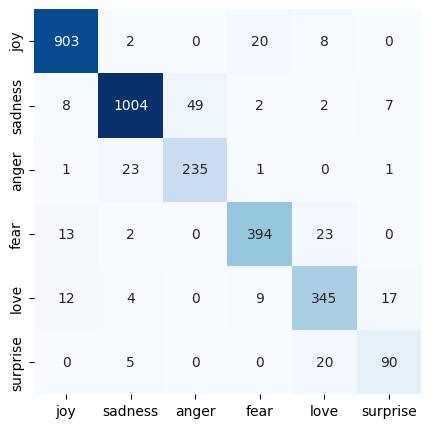

In [41]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, xticklabels=label2id.keys(), yticklabels=label2id.keys(), fmt='d', cbar=False, cmap='Blues')
plt.show()

## Saving Model

In [43]:
text = "I feel excited for today"

def get_prediction(text):
    input_encoded = tokenizer(text, return_tensors='pt').to(device)

    with torch.no_grad():
        outputs = model(**input_encoded)

    logits = outputs.logits

    pred = torch.argmax(logits, dim=1).item()
    return id2label[pred]

get_prediction(text)

'joy'

In [44]:
trainer.save_model("bert-base-uncased-sentiment-model")

In [45]:
# use pipeline for prediciton
from transformers import pipeline

classifier = pipeline('text-classification', model= 'bert-base-uncased-sentiment-model')

classifier([text, 'hello, how are you?', "love you", "i am feeling low"])

Device set to use cuda:0


[{'label': 'joy', 'score': 0.9935629367828369},
 {'label': 'joy', 'score': 0.9495819807052612},
 {'label': 'love', 'score': 0.9350161552429199},
 {'label': 'sadness', 'score': 0.9954659938812256}]

In [2]:
!pip install nbformat


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!python clean_widgets.py your_notebook.ipynb

Traceback (most recent call last):
  File "c:\Users\RAJ\Downloads\BERT_Fine_Tuning_Twitter_Sentiment_Analysis\clean_widgets.py", line 5, in <module>
    with open(sys.argv[1], 'r', encoding='utf-8') as f:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: 'your_notebook.ipynb'
